# Deep Learning Model - CNN and LSTM
Recurrent neural networks can obtain context information and the convolutional neural networks (CNN) excel at learning the spatial structure in input data. The text analysis method based on CNN can obtain important features of text through pooling but it is difficult to obtain contextual information. 

In this notebook I will apply CNN, bi-directional long-short term memory (bi-LSTM) models to the news dataset and compare their performance for text classification.

In [1]:
# filter out unncessary warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model

from official.nlp import optimization

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [3]:
# remove unnecessary TF logs
import logging
tf.get_logger().setLevel(logging.ERROR)

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [4]:
# check keras and TF version used
print('TF Version:', tf.__version__)
print('Keras Version:', keras.__version__)
print('Number of available GPUs:', len(tf.config.list_physical_devices('GPU')))

TF Version: 2.7.0
Keras Version: 2.7.0
Number of available GPUs: 1


In [5]:
# Read the data
df = pd.read_csv('../data/interim/covid_articles_preprocessed.csv')

## Merge Tags

tag_map = {'consumer':'general',
           'healthcare':'science',
           'automotive':'business',
           'environment':'science',
           'construction':'business',
           'ai':'tech'}

df['tags'] = [(lambda tags: tag_map[tags] if tags in tag_map.keys() else tags)(tags)
                          for tags in df['topic_area']]
df.tags.value_counts()

business    245652
general      86372
finance      22386
tech          8915
science       5595
Name: tags, dtype: int64

In [6]:
X = df.content.values
y = df.tags.values

enc = LabelEncoder()
y = enc.fit_transform(y)
enc_tags_mapping = dict(zip(enc.transform(enc.classes_), enc.classes_))

## Split the data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=21)

## Text processing
The `Tokenizer` class vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves.

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_validation = tokenizer.texts_to_sequences(X_validation)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

The `pad_sequences` class adds padding to the end of each article to ensure all entries are the same length (i.e., `maxlen` in this case).

In [8]:
maxlen = 700

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_validation = pad_sequences(X_validation, padding='post', maxlen=maxlen)

## CNN Model

In [13]:
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(tf.data.Dataset.from_tensor_slices(X_train)).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 7e-3
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [14]:
embedding_dim = 50

text_input = layers.Input(shape=(maxlen,), name='docs')

text_embeddings = layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen)(text_input)

conv_1 = layers.Conv1D(embedding_dim,2,strides=2, name='cnn_2')(text_embeddings)
conv_2 = layers.Conv1D(embedding_dim,3,strides=3, name='cnn_3')(text_embeddings)
conv_3 = layers.Conv1D(embedding_dim,4,strides=4, name='cnn_4')(text_embeddings)
conv_4 = layers.Conv1D(embedding_dim,5,strides=5, name='cnn_5')(text_embeddings)

pool_1 = layers.AveragePooling1D(pool_size=10, name='pooling_1')(conv_1)
pool_2 = layers.AveragePooling1D(pool_size=10, name='pooling_2')(conv_2)
pool_3 = layers.AveragePooling1D(pool_size=10, name='pooling_3')(conv_3)
pool_4 = layers.AveragePooling1D(pool_size=10, name='pooling_4')(conv_4)

hybrid_layer = layers.Concatenate(axis=1, name='hybrid_layer')([pool_1, pool_2, pool_3, pool_4])

flatten = layers.Flatten(name='faltten')(hybrid_layer)

dense = layers.Dense(512, activation='relu', name='Dense')(flatten)
dropout = layers.Dropout(0.5)(dense)

dense = layers.Dense(64, activation='relu', name='Dense_2')(dropout)
dropout = layers.Dropout(0.5)(dense)

output = layers.Dense(5, activation='softmax', name='classifier')(dropout)

model_CNN = Model(inputs=text_input, outputs=output)
model_CNN.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_CNN.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 docs (InputLayer)              [(None, 700)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 700, 50)      46890800    ['docs[0][0]']                   
                                                                                                  
 cnn_2 (Conv1D)                 (None, 350, 50)      5050        ['embedding_1[0][0]']            
                                                                                                  
 cnn_3 (Conv1D)                 (None, 233, 50)      7550        ['embedding_1[0][0]']            
                                                                                            

In [15]:
checkpoint_path = "../models/DL/lstm-train/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
my_callbacks = [
                keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=False),
                keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=4,
                                              restore_best_weights=False),
                ]

history_CNN = model_CNN.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_validation, y_validation),
                    batch_size=500,
                    callbacks=[my_callbacks])

Epoch 1/50
414/414 [==============================] - 124s 298ms/step - loss: 1.5046 - accuracy: 0.4914 - val_loss: 1.2587 - val_accuracy: 0.6689
Epoch 2/50
414/414 [==============================] - 123s 297ms/step - loss: 1.0598 - accuracy: 0.6601 - val_loss: 0.8897 - val_accuracy: 0.6689
Epoch 3/50
414/414 [==============================] - 122s 296ms/step - loss: 0.8748 - accuracy: 0.6938 - val_loss: 0.7127 - val_accuracy: 0.7691
Epoch 4/50
414/414 [==============================] - 122s 295ms/step - loss: 0.6822 - accuracy: 0.7868 - val_loss: 0.5730 - val_accuracy: 0.8107
Epoch 5/50
414/414 [==============================] - 122s 294ms/step - loss: 0.5568 - accuracy: 0.8214 - val_loss: 0.4788 - val_accuracy: 0.8297
Epoch 6/50
414/414 [==============================] - 121s 293ms/step - loss: 0.4552 - accuracy: 0.8457 - val_loss: 0.4042 - val_accuracy: 0.8555
Epoch 7/50
414/414 [==============================] - 121s 293ms/step - loss: 0.3790 - accuracy: 0.8740 - val_loss: 0.3569 -

The model overfit to the training data. I added dropout layers and early stopping to mitigate this issue. Now, let's check the performance of the model on test data.

In [16]:
y_pred_prob = model_CNN.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
print(classification_report(y_test, y_pred, target_names=list(enc_tags_mapping.values())))

              precision    recall  f1-score   support

    business       0.92      0.97      0.94     73935
     finance       0.89      0.74      0.81      6788
     general       0.91      0.87      0.89     25646
     science       0.47      0.09      0.15      1690
        tech       0.52      0.52      0.52      2617

    accuracy                           0.91    110676
   macro avg       0.74      0.64      0.66    110676
weighted avg       0.90      0.91      0.90    110676



In [17]:
## Saving the model
model_CNN.save( "../models/DL/cnn-model-3")

# LSTM
Now, I will add an LSTM layer to the model to compare its performance with previous architecture.

In [13]:
embedding_dim = 16

model_hybrid = Sequential()
model_hybrid.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model_hybrid.add(layers.Conv1D(16,2,strides=2))
model_hybrid.add(layers.AveragePooling1D(pool_size=3))
model_hybrid.add(layers.Bidirectional(layers.LSTM(16)))
model_hybrid.add(layers.Dropout(rate=0.5, seed=21))
model_hybrid.add(layers.Dense(256, activation='relu'))
model_hybrid.add(layers.Dense(5, activation='softmax'))
model_hybrid.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_hybrid.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 700, 16)           15005056  
                                                                 
 conv1d (Conv1D)             (None, 350, 16)           528       
                                                                 
 average_pooling1d (AverageP  (None, 116, 16)          0         
 ooling1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 32)               4224      
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 256)               8

In [14]:
checkpoint_path = "../models/DL/lstm-train/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
my_callbacks = [
                keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=False),
                keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
                ]


history_hybrid = model_hybrid.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_validation, y_validation),
                    batch_size=3000,
                    callbacks=[my_callbacks])

#model_hybrid.save('../models/DL/lstm-model/my_model-lstm')

Epoch 1/50
69/69 [==============================] - 30s 357ms/step - loss: 1.0951 - accuracy: 0.6577 - val_loss: 0.8895 - val_accuracy: 0.6689
Epoch 2/50
69/69 [==============================] - 23s 333ms/step - loss: 0.6954 - accuracy: 0.7602 - val_loss: 0.5219 - val_accuracy: 0.8244
Epoch 3/50
69/69 [==============================] - 23s 331ms/step - loss: 0.4556 - accuracy: 0.8445 - val_loss: 0.4112 - val_accuracy: 0.8490
Epoch 4/50
69/69 [==============================] - 23s 331ms/step - loss: 0.3321 - accuracy: 0.8817 - val_loss: 0.3524 - val_accuracy: 0.8763
Epoch 5/50
69/69 [==============================] - 23s 332ms/step - loss: 0.2381 - accuracy: 0.9159 - val_loss: 0.3369 - val_accuracy: 0.8870
Epoch 6/50
69/69 [==============================] - 23s 331ms/step - loss: 0.1716 - accuracy: 0.9397 - val_loss: 0.3549 - val_accuracy: 0.8913
Epoch 7/50
69/69 [==============================] - 23s 330ms/step - loss: 0.1257 - accuracy: 0.9549 - val_loss: 0.3901 - val_accuracy: 0.8893

Plotting the `history` will help to better understand the fitting process.

In [15]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 0.9743
Validation Accuracy:  0.8926


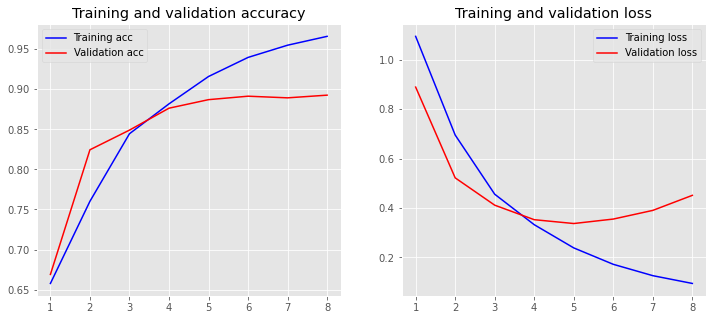

In [16]:
loss, accuracy = model_hybrid.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_hybrid.evaluate(X_validation, y_validation, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
plot_history(history_hybrid)

In [17]:
y_pred_prob = model_hybrid.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
print(classification_report(y_test, y_pred, target_names=list(enc_tags_mapping.values())))

              precision    recall  f1-score   support

    business       0.93      0.95      0.94     73935
     finance       0.70      0.74      0.72      6788
     general       0.89      0.87      0.88     25646
     science       0.00      0.00      0.00      1690
        tech       0.37      0.43      0.40      2617

    accuracy                           0.89    110676
   macro avg       0.58      0.60      0.59    110676
weighted avg       0.88      0.89      0.89    110676



Results indicate that the CNN model performs better for classification of the articles in this problem.